In [1]:
plot_to_pdf = True

if plot_to_pdf:
    import matplotlib as mpl
    mpl.use('pdf')
    
    import matplotlib.pyplot as plt
    
    plt.rc('font', family='serif', serif='Times')
    plt.rc('text', usetex=True)
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('axes', labelsize=10)
    plt.rc('legend', fontsize=10)
    title_font_size = 12
    data_font_size = 8
else:
    import matplotlib.pyplot as plt

from sympy import Symbol, diff, simplify, latex
import numpy as np
import time
from tqdm.notebook import tqdm
from common import *
    
%matplotlib inline

common.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


# Analysis of SmoothL1, Huber, Pseudo-Huber

Here we do a grid search over parameters $\beta$ and weighing term of each of the functions. They are related in the sense that all have an L1 part (for $|x| > \beta$) and an L2 part (for $|x| \leq \beta$)

### Opt. Problem
$$
\text{min} \sum_{t=0}^{T-1} \big( x^T Q x  + \sum_i \lambda\color{blue}{f(u_t[i])} \big) + x_T^T Q_f x_T
$$

**L2**
$$
    f(x) = x^2
$$

**SmoothL1**
\begin{align*}
    f(x) = \begin{cases}
            0.5 x^2/\beta &\mbox{if}\ |x| \leq \beta \\
            |x| - 0.5 \beta &\mbox{otherwise}
        \end{cases}
\end{align*}


**Huber**
\begin{align*}
    f(x) = \begin{cases}
            0.5 x^2 &\mbox{if}\ |x| \leq \beta \\
            \beta(|x| - 0.5 \beta) &\mbox{otherwise}
        \end{cases}
\end{align*}

**Pseudo-Huber**
$$
f(x) = \beta^2 \bigg(\sqrt{(1 + \frac{x}{\beta}^2)} - 1\bigg)
$$

In [2]:
def smooth_l1(x, beta):
    if np.abs(x) < beta:
        return 0.5 * x * x / beta
    return np.abs(x) - 0.5 * beta

def huber(x, beta):
    if np.abs(x) < beta:
        return 0.5 * x * x
    else:
        return beta * (np.abs(x) - 0.5 * beta)

def pseudo_huber(x, beta):
    return beta * beta * (np.sqrt(1 + np.power(x / beta, 2)) - 1.0)

# Figure 2. Plot of sparse functions

/home/tdinev/miniconda3/envs/py2gen/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


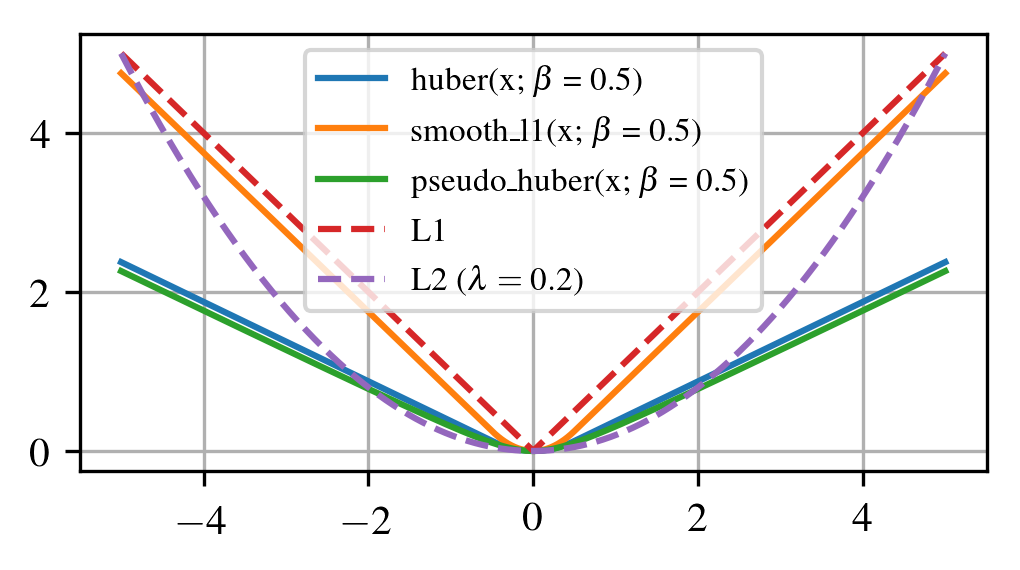

In [3]:
xs = np.linspace(-5, 5, 1000) #np.linspace(-15, 15, 1000)

fig = plt.figure()
fig.set_size_inches(3.5, 2) #1.5)
fig.set_dpi(300)

plt.plot(xs, [huber(x, beta=0.5) for x in xs], label=r'huber(x; $\beta$ = 0.5)')
plt.plot(xs, [smooth_l1(x, beta=0.5) for x in xs], label=r'smooth\_l1(x; $\beta$ = 0.5)')
plt.plot(xs, [pseudo_huber(x, beta=0.5) for x in xs], label=r'pseudo\_huber(x; $\beta$ = 0.5)')
plt.plot(xs, np.abs(xs), '--', label='L1',)
plt.plot(xs, 0.2 * np.square(xs), '--', label='L2 ($\lambda=0.2$)',)
plt.legend(fontsize=8)
plt.grid()

plt.tight_layout()

# L2 Solution

Final Task Cost: 1.51415986375e-07


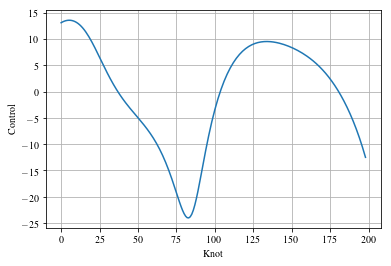

In [4]:
l2_problem, l2_solver = load_problem(
    'configs/cartpole.xml',
    problem_name='cartpole', solver_name='ADDP', problem_params={
# ==========================================
        'LossType': 'L2',
        'HuberRate': '0',
        'R_rate': '1e-4',
        'ControlCostWeight': '1',
        'Qf_rate': str(1e3)
# ==========================================
    })
l2_solver.max_iterations = 100
l2_solver.debug_mode = True
l2_solution_cartpole = l2_solver.solve()

print('Final Task Cost: {0}'.format(l2_problem.get_state_cost(-1)))
plt.plot(l2_solution_cartpole)
plt.grid()
plt.xlabel('Knot')
plt.ylabel('Control');

# Grid Search Parametrization

In [5]:
betas_grid = 10 ** np.linspace(-5, 0, 10)
weights_grid = 10 ** np.linspace(-3, 3, 10)
qf_rate = 1e3
max_iter = 5000
r_rate = 0

# SmoothL1 Grid Search

In [7]:
smooth_l1_num_zeros_grid = []
smooth_l1_final_costs_grid = []
smooth_l1_solutions_grid = []
smooth_l1_cost_evolutions_grid = []

for beta in tqdm(betas_grid):
    num_zeros_ = []
    final_costs_ = []
    solutions_ = []
    cost_evolutions_ = []
    
    for weight in weights_grid:
    
        problem, solver = load_problem(
        'configs/cartpole.xml',
        problem_name='cartpole', solver_name='ADDP', problem_params={
        # ==========================================
                'LossType': 'SmoothL1',
                'L1Rate': str(beta),
                'ControlCostWeight': str(weight),
                'Qf_rate': str(qf_rate),
                'R_rate': str(r_rate)
        # ==========================================
        })

        solver.max_iterations = max_iter
        solver.debug_mode = True
        solution = solver.solve()
    
        num_zero = np.sum(np.isclose(solution, 0, atol=beta))
        num_zeros_.append(num_zero)

        final_cost = problem.get_state_cost(-1)
        final_costs_.append(final_cost)
        
        cost_evolutions_.append(problem.get_cost_evolution())
        solutions_.append(solution)
        
    smooth_l1_num_zeros_grid.append(num_zeros_)
    smooth_l1_final_costs_grid.append(final_costs_)
    smooth_l1_solutions_grid.append(solutions_)
    smooth_l1_cost_evolutions_grid.append(cost_evolutions_)

# Figure 3. SmoothL1 Grid Search

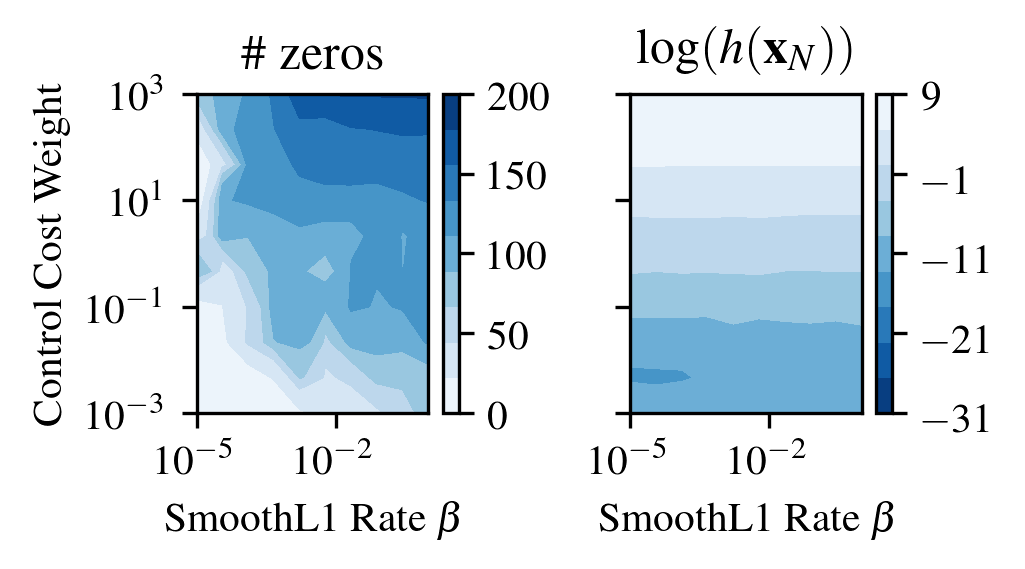

In [8]:
# fig, ax = plt.subplots(1, 2, figsize=(6,3)) #(16, 7))
fig, ax = plt.subplots(1, 2, sharey=True, sharex=True)
fig.set_size_inches(3.5, 2)
fig.set_dpi(300)

cbarticks = np.linspace(0, 200, 10)
cs1 = ax[0].contourf(
    betas_grid, weights_grid, np.power(smooth_l1_num_zeros_grid, 1).T,
    cbarticks,
    cmap=plt.cm.Blues, vmin=0, vmax=200
)
ax[0].set_xlabel(r'SmoothL1 Rate $\beta$')
ax[0].set_ylabel('Control Cost Weight')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
cbar = fig.colorbar(cs1,ax = ax[0])
cbar.set_ticks([int(x) for x in np.linspace(cbar.get_ticks()[0], cbar.get_ticks()[-1], 5)])

cbarticks = np.linspace(-31, 9, 10)
ax[0].set_title(r'\# zeros')

cs2 = ax[1].contourf(
    betas_grid, weights_grid, np.log(smooth_l1_final_costs_grid).T,
    cbarticks,
    cmap=plt.cm.Blues_r, vmin=-31, vmax=9
)
ax[1].set_xlabel(r'SmoothL1 Rate $\beta$')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
cbar = fig.colorbar(cs2, ax=ax[1])
cbar.set_ticks([int(x) for x in np.linspace(cbar.get_ticks()[0], cbar.get_ticks()[-1], 5)])

ax[1].set_title(r'$\log(h(\mathbf{x}_N))$')

plt.tight_layout()

# Huber Grid Search

In [9]:
huber_num_zeros_grid = []
huber_final_costs_grid = []
huber_solutions_grid = []
huber_cost_evolutions_grid = []

for beta in tqdm(betas_grid):
    num_zeros_ = []
    final_costs_ = []
    solutions_ = []
    cost_evolutions_ = []
    
    for weight in weights_grid:
    
        problem, solver = load_problem(
        'configs/cartpole.xml',
        problem_name='cartpole', solver_name='ADDP', problem_params={
        # ==========================================
                'LossType': 'Huber',
                'HuberRate': str(beta),
                'ControlCostWeight': str(weight),
                'Qf_rate': str(qf_rate),
                'R_rate': str(r_rate)
        # ==========================================
        })

        solver.max_iterations = max_iter
        solver.debug_mode = True
        solution = solver.solve()
    
        num_zero = np.sum(np.isclose(solution, 0, atol=beta))
        num_zeros_.append(num_zero)

        final_cost = problem.get_state_cost(-1)
        final_costs_.append(final_cost)
        
        cost_evolutions_.append(problem.get_cost_evolution())
        solutions_.append(solution)

    huber_num_zeros_grid.append(num_zeros_)
    huber_final_costs_grid.append(final_costs_)
    
    huber_solutions_grid.append(solutions_)
    huber_cost_evolutions_grid.append(cost_evolutions_)

# Figure 3. Huber Grid Search

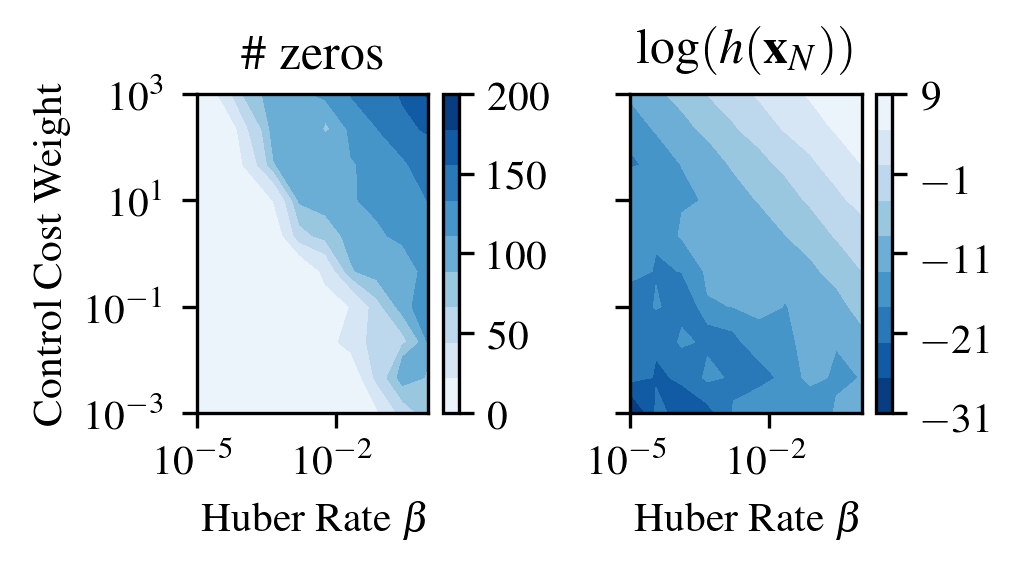

In [10]:
fig, ax = plt.subplots(1, 2, sharey=True, sharex=True)
fig.set_size_inches(3.5, 2)
fig.set_dpi(300)

cbarticks = np.linspace(0, 200, 10)
cs1 = ax[0].contourf(
    betas_grid, weights_grid, np.power(huber_num_zeros_grid, 1).T,
    cbarticks,
    cmap=plt.cm.Blues, vmin=0, vmax=200
)
ax[0].set_xlabel(r'Huber Rate $\beta$')
ax[0].set_ylabel('Control Cost Weight')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
cbar = fig.colorbar(cs1,ax = ax[0])
cbar.set_ticks([int(x) for x in np.linspace(cbar.get_ticks()[0], cbar.get_ticks()[-1], 5)])

cbarticks = np.linspace(-31, 9, 10)
ax[0].set_title(r'\# zeros')

cs2 = ax[1].contourf(
    betas_grid, weights_grid, np.log(huber_final_costs_grid).T,
    cbarticks,
    cmap=plt.cm.Blues_r, vmin=-31, vmax=9
)
ax[1].set_xlabel(r'Huber Rate $\beta$')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
cbar = fig.colorbar(cs2, ax=ax[1])
cbar.set_ticks([int(x) for x in np.linspace(cbar.get_ticks()[0], cbar.get_ticks()[-1], 5)])

ax[1].set_title(r'$\log(h(\mathbf{x}_N))$')

plt.tight_layout()

# Pseudo Huber Grid Search

In [11]:
pseudo_huber_num_zeros_grid = []
pseudo_huber_final_costs_grid = []
pseudo_huber_solutions_grid = []
pseudo_huber_cost_evolutions_grid = []

for beta in tqdm(betas_grid):
    num_zeros_ = []
    final_costs_ = []
    solutions_ = []
    cost_evolutions_ = []
    
    for weight in weights_grid:
    
        problem, solver = load_problem(
        'configs/cartpole.xml',
        problem_name='cartpole', solver_name='ADDP', problem_params={
        # ==========================================
                'LossType': 'PseudoHuber',
                'HuberRate': str(beta),
                'ControlCostWeight': str(weight),
                'Qf_rate': str(qf_rate),
                'R_rate': str(r_rate)
        # ==========================================
        })

        solver.max_iterations = max_iter
        solver.debug_mode = True
        solution = solver.solve()
    
        num_zero = np.sum(np.isclose(solution, 0, atol=beta))
        num_zeros_.append(num_zero)

        final_cost = problem.get_state_cost(-1)
        final_costs_.append(final_cost)
        
        cost_evolutions_.append(problem.get_cost_evolution())
        solutions_.append(solution)
        
    pseudo_huber_num_zeros_grid.append(num_zeros_)
    pseudo_huber_final_costs_grid.append(final_costs_)
    pseudo_huber_solutions_grid.append(solutions_)
    pseudo_huber_cost_evolutions_grid.append(cost_evolutions_)

# Figure 3. PseudoHuber Grid Search

Text(0.5,1,'$\\log(h(\\mathbf{x}_N))$')

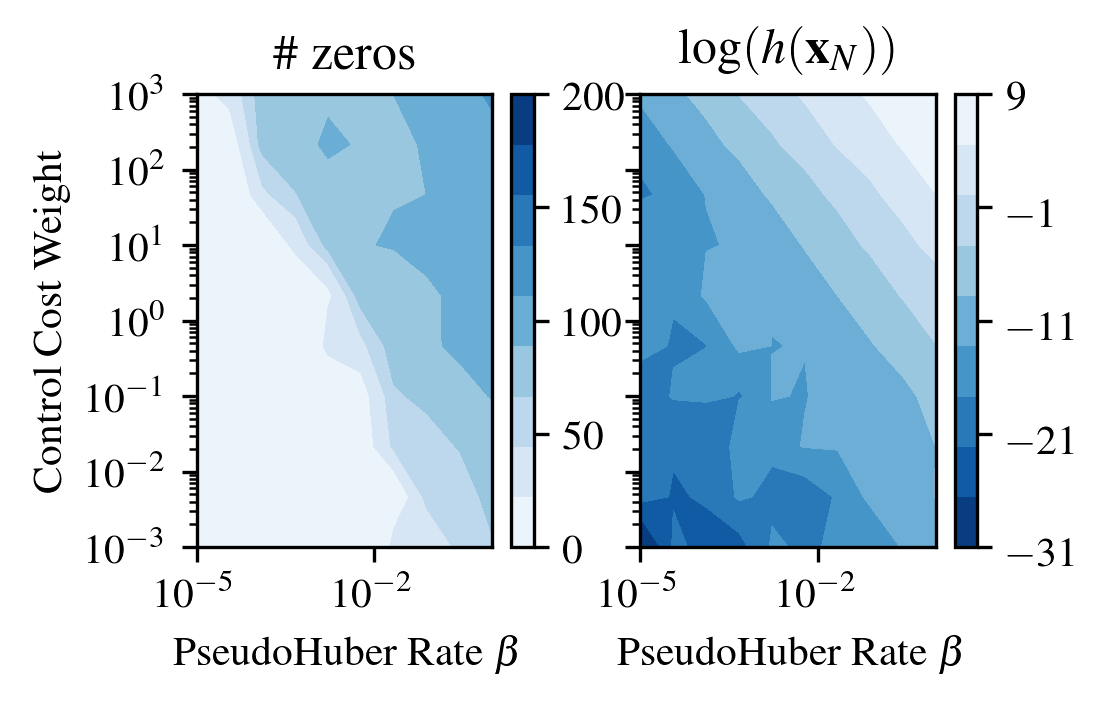

In [12]:
fig, ax = plt.subplots(1, 2, sharey=True, sharex=True)
fig.set_size_inches(3.5, 2)
fig.set_dpi(300)

cbarticks = np.linspace(0, 200, 10)
cs1 = ax[0].contourf(
    betas_grid, weights_grid, np.power(pseudo_huber_num_zeros_grid, 1).T,
    cbarticks,
    cmap=plt.cm.Blues, vmin=0, vmax=200
)
ax[0].set_xlabel(r'PseudoHuber Rate $\beta$')
ax[0].set_ylabel('Control Cost Weight')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
cbar = fig.colorbar(cs1,ax = ax[0])
cbar.set_ticks([int(x) for x in np.linspace(cbar.get_ticks()[0], cbar.get_ticks()[-1], 5)])

cbarticks = np.linspace(-31, 9, 10)
ax[0].set_title(r'\# zeros')

cs2 = ax[1].contourf(
    betas_grid, weights_grid, np.log(pseudo_huber_final_costs_grid).T,
    cbarticks,
    cmap=plt.cm.Blues_r, vmin=-31, vmax=9
)
ax[1].set_xlabel(r'PseudoHuber Rate $\beta$')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
cbar = fig.colorbar(cs2, ax=ax[1])
cbar.set_ticks([int(x) for x in np.linspace(cbar.get_ticks()[0], cbar.get_ticks()[-1], 5)])

ax[1].set_title(r'$\log(h(\mathbf{x}_N))$')


# Plot Sample Sparse solutions

In [13]:
grid_params = []
for beta in tqdm(betas_grid):
    grid_params_ = []
    for weight in weights_grid:
        grid_params_.append((beta, weight))
    grid_params.append(grid_params_)

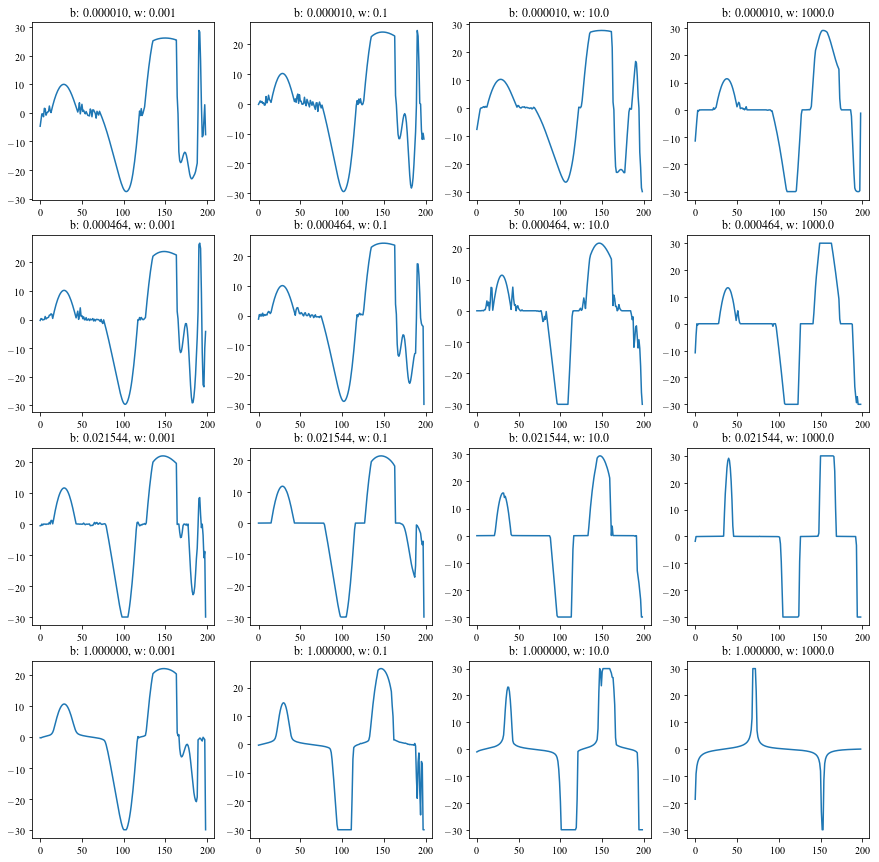

In [14]:
fig = plt.figure() #figsize=(13,6))
fig.set_size_inches(15, 15)

for i, c in enumerate([
    [0, 0], [0, 3], [0, 6], [0, 9],
    [3, 0], [3, 3], [3, 6], [3, 9],
    [6, 0], [6, 3], [6, 6], [6, 9],
    [9, 0], [9, 3], [9, 6], [9, 9],
]):
    ax = plt.subplot(4,4,i + 1)
    plt.plot(pseudo_huber_solutions_grid[c[0]][c[1]]);
    plt.title('b: {0:.6f}, w: {1}'.format(*grid_params[c[0]][c[1]]))


# Generate Solutions With Poorly Tuned Hyperparameters

Final Task Cost 5.41587809151e-06


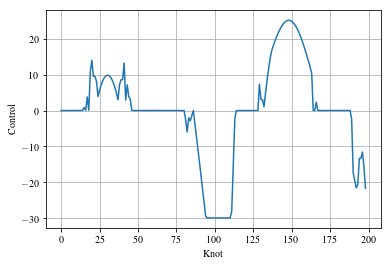

In [15]:
_problem_sl1_bad, _solver_sl1_bad = load_problem(
    'configs/cartpole.xml',
    problem_name='cartpole', solver_name='ADDP', problem_params={
# ==========================================
        'LossType': 'SmoothL1',
        'HuberRate': '0',
        'R_rate': '0',
        'ControlCostWeight': '0.01',
        'L1Rate': '1e-3',
        'Qf_rate': '1e3'
# ==========================================
    })
_solver_sl1_bad.max_iterations = 10000
_solver_sl1_bad.debug_mode = True
_solution_sl1_bad = _solver_sl1_bad.solve()

print('Final Task Cost {0}'.format(_problem_sl1_bad.get_state_cost(-1)))
plt.plot(_solution_sl1_bad)
plt.grid()
plt.xlabel('Knot')
plt.ylabel('Control');

Final Task Cost 2.91993123807e-06


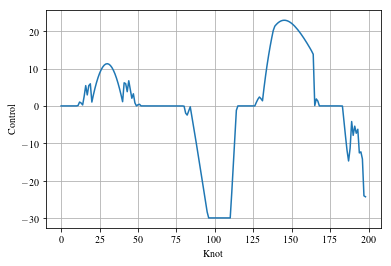

In [16]:
_problem_h_bad, _solver_h_bad = load_problem(
    'configs/cartpole.xml',
    problem_name='cartpole', solver_name='ADDP', problem_params={
# ==========================================
        'LossType': 'Huber',
        'HuberRate': '0',
        'R_rate': '0',
        'ControlCostWeight': '7',
        'HuberRate': '1e-3',
        'Qf_rate': '1e3'
# ==========================================
    })
_solver_h_bad.max_iterations = 10000
_solver_h_bad.debug_mode = True
_solution_h_bad = _solver_h_bad.solve()

print('Final Task Cost {0}'.format(_problem_h_bad.get_state_cost(-1)))
plt.plot(_solution_h_bad)
plt.grid()
plt.xlabel('Knot')
plt.ylabel('Control');

Final Task Cost 4.65981715556e-06


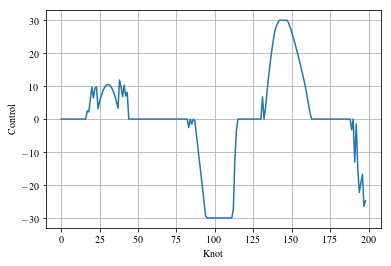

In [17]:
_problem_ph_bad, _solver_ph_bad = load_problem(
    'configs/cartpole.xml',
    problem_name='cartpole', solver_name='ADDP', problem_params={
# ==========================================
        'LossType': 'PseudoHuber',
        'HuberRate': '0',
        'R_rate': '0',
        'ControlCostWeight': '9',
        'HuberRate': '1e-3',
        'Qf_rate': '1e3'
# ==========================================
    })
_solver_ph_bad.max_iterations = 10000
_solver_ph_bad.debug_mode = True
_solution_ph_bad = _solver_ph_bad.solve()

print('Final Task Cost {0}'.format(_problem_ph_bad.get_state_cost(-1)))
plt.plot(_solution_ph_bad)
plt.grid()
plt.xlabel('Knot')
plt.ylabel('Control');

In [18]:
print('SmoothL1, # zero: {0}, cost {1}'.format(
    np.sum(np.isclose(_solution_sl1_bad, 0, atol=1e-3)),
    _problem_sl1_bad.get_state_cost(-1)
))

print('Huber, # zero: {0}, cost {1}'.format(
    np.sum(np.isclose(_solution_h_bad, 0, atol=1e-3)),
    _problem_h_bad.get_state_cost(-1)
))

print('PseudoHuber, # zero: {0}, cost {1}'.format(
    np.sum(np.isclose(_solution_ph_bad, 0, atol=1e-3)),
    _problem_ph_bad.get_state_cost(-1)
))

SmoothL1, # zero: 73, cost 5.41587809151e-06
Huber, # zero: 58, cost 2.91993123807e-06
PseudoHuber, # zero: 86, cost 4.65981715556e-06


In [19]:
times = [0]
for i in range(l2_problem.T - 1):
    times.append(times[i] + l2_problem.tau)
times = times[1:]

# Figure 4. Example Sparse Solutions With Artifacts

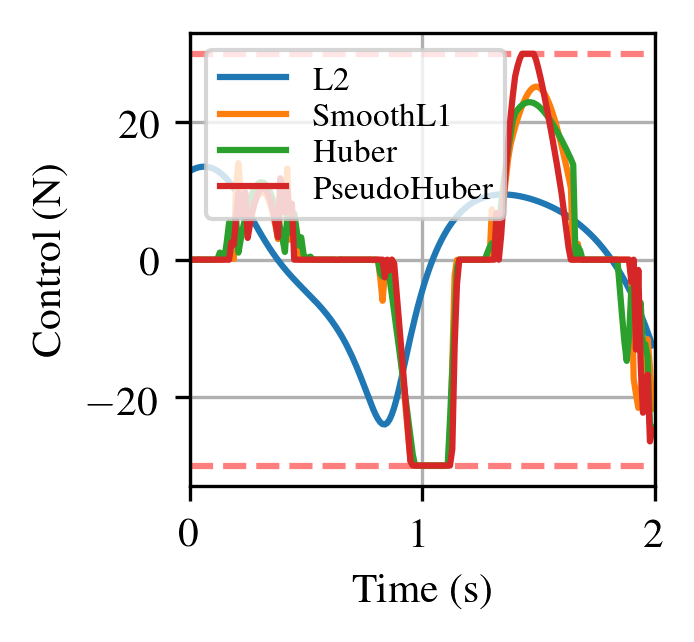

In [21]:
# idx = 35
fig = plt.figure()
fig.set_size_inches(2, 2)
fig.set_dpi(300)

plt.plot(times, l2_solution_cartpole, label='L2')
plt.plot(times, _solution_sl1_bad, label='SmoothL1')
plt.plot(times, _solution_h_bad, label='Huber')
plt.plot(times, _solution_ph_bad, label='PseudoHuber')

plt.hlines(30, 0, times[-1], 'r', '--', alpha=0.5)
plt.hlines(-30, 0, times[-1], 'r', '--', alpha=0.5)
plt.xlim(0, times[-1])
plt.xticks([0, 1, 2])

plt.xlabel('Time (s)')
plt.ylabel(r'Control (N)')

plt.grid()
plt.legend(fontsize=8, frameon=True, labelspacing=0.1)


# Generate Solutions With Tuned Hyperparameters

Final Task Cost 2.70533606496e-05


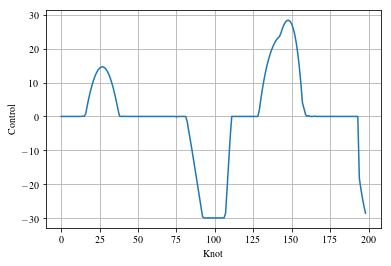

In [22]:
_problem_sl1, _solver_sl1 = load_problem(
    'configs/cartpole.xml',
    problem_name='cartpole', solver_name='ADDP', problem_params={
# ==========================================
        'LossType': 'SmoothL1',
        'HuberRate': '0',
        'R_rate': '0',
        'ControlCostWeight': '0.023',
        'L1Rate': '1e-3',
        'Qf_rate': '1e3'
# ==========================================
    })
_solver_sl1.max_iterations = 10000
_solver_sl1.debug_mode = True
_solution_sl1 = _solver_sl1.solve()

print('Final Task Cost {0}'.format(_problem_sl1.get_state_cost(-1)))
plt.plot(_solution_sl1)
plt.grid()
plt.xlabel('Knot')
plt.ylabel('Control');

Final Task Cost 4.495169553e-05


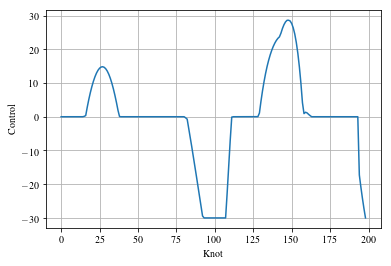

In [23]:
_problem_h, _solver_h = load_problem(
    'configs/cartpole.xml',
    problem_name='cartpole', solver_name='ADDP', problem_params={
# ==========================================
        'LossType': 'Huber',
        'HuberRate': '0',
        'R_rate': '0',
        'ControlCostWeight': '25',
        'HuberRate': '1e-3',
        'Qf_rate': '1e3'
# ==========================================
    })
_solver_h.max_iterations = 10000
_solver_h.debug_mode = True
_solution_h = _solver_h.solve()


print('Final Task Cost {0}'.format(_problem_h.get_state_cost(-1)))
plt.plot(_solution_h)
plt.grid()
plt.xlabel('Knot')
plt.ylabel('Control');

Final Task Cost 4.70855599724e-05


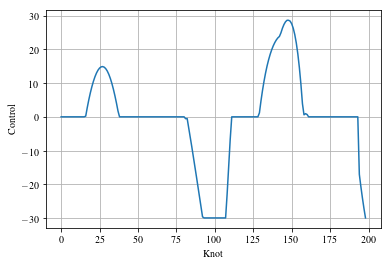

In [24]:
_problem_ph, _solver_ph = load_problem(
    'configs/cartpole.xml',
    problem_name='cartpole', solver_name='ADDP', problem_params={
# ==========================================
        'LossType': 'PseudoHuber',
        'HuberRate': '0',
        'R_rate': '0',
        'ControlCostWeight': '25',
        'HuberRate': '1e-3',
        'Qf_rate': '1e3'
# ==========================================
    })
_solver_ph.max_iterations = 10000
_solver_ph.debug_mode = True
_solution_ph = _solver_ph.solve()

print('Final Task Cost {0}'.format(_problem_ph.get_state_cost(-1)))
plt.plot(_solution_ph)
plt.grid()
plt.xlabel('Knot')
plt.ylabel('Control');

In [25]:
print('SmoothL1, # zero: {0}, cost {1}'.format(
    np.sum(np.isclose(_solution_sl1, 0, atol=1e-3)),
    _problem_sl1.get_state_cost(-1)
))

print('Huber, # zero: {0}, cost {1}'.format(
    np.sum(np.isclose(_solution_h, 0, atol=1e-3)),
    _problem_h.get_state_cost(-1)
))

print('PseudoHuber, # zero: {0}, cost {1}'.format(
    np.sum(np.isclose(_solution_ph, 0, atol=1e-3)),
    _problem_ph.get_state_cost(-1)
))

SmoothL1, # zero: 101, cost 2.70533606496e-05
Huber, # zero: 102, cost 4.495169553e-05
PseudoHuber, # zero: 89, cost 4.70855599724e-05


# Figure 5. Sparse Solutions

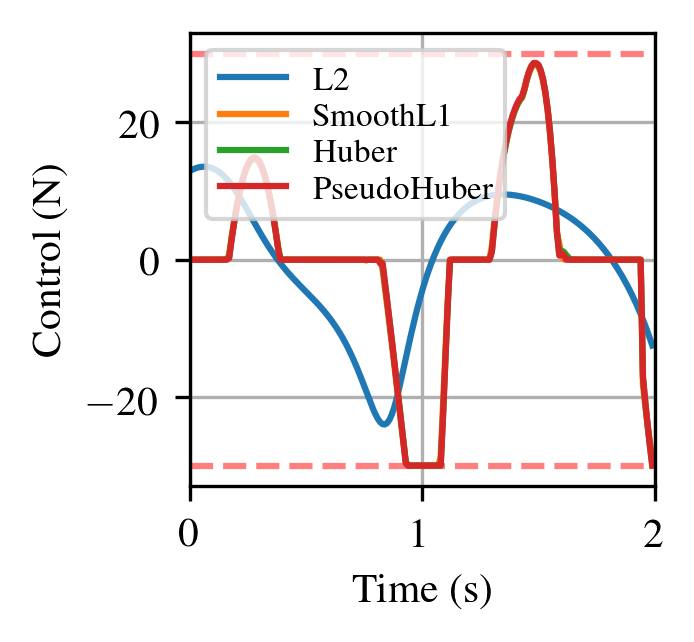

In [26]:
# idx = 35
fig = plt.figure()
fig.set_size_inches(2, 2)
fig.set_dpi(300)

plt.plot(times, l2_solution_cartpole, label='L2')
plt.plot(times, _solution_sl1, label='SmoothL1')
plt.plot(times, _solution_h, label='Huber')
plt.plot(times, _solution_ph, label='PseudoHuber')

plt.hlines(30, 0, times[-1], 'r', '--', alpha=0.5)
plt.hlines(-30, 0, times[-1], 'r', '--', alpha=0.5)
plt.xlim(0, times[-1])
plt.xticks([0, 1, 2])
plt.xlabel('Time (s)')
plt.ylabel('Control (N)')

# plt.xlabel('Time-step')
# plt.ylabel(r'$u$')

plt.grid()
plt.legend(fontsize=8, frameon=True, labelspacing=0.1)